# Ray Parallel Training Lab - Diabetes Progression Prediction

## Preliminaries

In [1]:
import time
from operator import itemgetter
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
import ray

## Prepare Dataset

In [2]:
# Loading Diabetes dataset
diabetes = load_diabetes(as_frame=True)
X, y = diabetes.data, diabetes.target

In [3]:
print(f"Dataset shape: {X.shape}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")
print(f"Target mean: {y.mean():.2f}, std: {y.std():.2f}")
print(f"Features:{list(X.columns)}")

Dataset shape: (442, 10)
Target range: [25.00, 346.00]
Target mean: 152.13, std: 77.09
Features:['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [4]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [5]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 353
Test set size: 89


In [6]:
# Benchmark parameter - number of models to train
NUM_MODELS = 20

## Sequential Implementation

In [7]:
def train_and_score_model(
    train_set: pd.DataFrame,
    test_set: pd.DataFrame,
    train_labels: pd.Series,
    test_labels: pd.Series,
    n_estimators: int,
    learning_rate: float,
    max_depth: int,
) -> tuple[int, float, int, float, float, float]:
    start_time = time.time()
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )
    model.fit(train_set, train_labels)
    y_pred = model.predict(test_set)
    
    mse = mean_squared_error(test_labels, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_labels, y_pred)
    mae = mean_absolute_error(test_labels, y_pred)
    
    time_delta = time.time() - start_time
    print(f"n_est={n_estimators:3d}, lr={learning_rate:.3f}, depth={max_depth}, "
          f"RMSE={rmse:.2f}, R²={r2:.4f}, took: {time_delta:.2f}s")
    
    return n_estimators, learning_rate, max_depth, rmse, r2, mae

In [8]:
def run_sequential(n_models: int) -> list[tuple]:
    results = []
    for j in range(n_models):
        n_estimators = 50 + 10 * j         
        learning_rate = 0.05 + 0.005 * j   
        max_depth = 2 + j // 5             
        
        result = train_and_score_model(
            train_set=X_train,
            test_set=X_test,
            train_labels=y_train,
            test_labels=y_test,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
        )
        results.append(result)
    return results

This function trains `NUM_MODELS` sequentially with varying hyperparameters:
- **n_estimators**: increases by 10 for each model (50, 60, 70, ..., 240)
- **learning_rate**: increases by 0.005 for each model (0.05, 0.055, 0.06, ..., 0.145)
- **max_depth**: increases by 1 every 5 models (2, 2, 2, 2, 2, 3, 3, 3, 3, 3, ...)

`run_sequential` returns a list of tuples:
```python
[(n_estimators, learning_rate, max_depth, rmse, r2, mae), ...]
```

## Running Sequential Training

In [9]:
%%time
print("SEQUENTIAL TRAINING - GRADIENT BOOSTING\n")

seq_start_time = time.time()
sequential_results = run_sequential(n_models=NUM_MODELS)
seq_time = time.time() - seq_start_time
print("\n✓ Sequential training completed!")

SEQUENTIAL TRAINING - GRADIENT BOOSTING

n_est= 50, lr=0.050, depth=2, RMSE=53.19, R²=0.4659, took: 0.05s
n_est= 60, lr=0.055, depth=2, RMSE=52.49, R²=0.4799, took: 0.03s
n_est= 70, lr=0.060, depth=2, RMSE=52.54, R²=0.4791, took: 0.03s
n_est= 80, lr=0.065, depth=2, RMSE=52.42, R²=0.4814, took: 0.03s
n_est= 90, lr=0.070, depth=2, RMSE=52.54, R²=0.4789, took: 0.03s
n_est=100, lr=0.075, depth=3, RMSE=53.31, R²=0.4635, took: 0.05s
n_est=110, lr=0.080, depth=3, RMSE=54.41, R²=0.4413, took: 0.05s
n_est=120, lr=0.085, depth=3, RMSE=53.74, R²=0.4549, took: 0.06s
n_est=130, lr=0.090, depth=3, RMSE=53.97, R²=0.4502, took: 0.06s
n_est=140, lr=0.095, depth=3, RMSE=55.48, R²=0.4190, took: 0.07s
n_est=150, lr=0.100, depth=4, RMSE=55.86, R²=0.4110, took: 0.09s
n_est=160, lr=0.105, depth=4, RMSE=57.59, R²=0.3739, took: 0.10s
n_est=170, lr=0.110, depth=4, RMSE=57.58, R²=0.3742, took: 0.10s
n_est=180, lr=0.115, depth=4, RMSE=57.83, R²=0.3689, took: 0.11s
n_est=190, lr=0.120, depth=4, RMSE=58.29, R²=0.35

### Analyze results

In [10]:
# Best models (lowest RMSE is the best)
best_seq = min(sequential_results, key=itemgetter(3))
print(f"Best Sequential Model: RMSE={best_seq[3]:.2f}, n_estimators={best_seq[0]}")

Best Sequential Model: RMSE=52.42, n_estimators=80


## Parallel Implementation

In contrast to the previous approach, we will now utilize all available resources to train these models in parallel. Ray will automatically detect the number of cores on the computer or the amount of resources in a cluster to distribute each defined task.

The diagram below offers an intuition for how tasks are assigned and executed in a parallel approach. We notice that this introduces a scheduler which is responsible for managing incoming requests, assigning nodes and detecting available resources.

```
           ┌─ Model 1
           ├─ Model 2
Scheduler ─┤  Model 3   (all running simultaneously)
           ├─ Model 4
           └─ Model ...
```

In [11]:
print("Initializing Ray...")
if ray.is_initialized():
    ray.shutdown()
ray.init(ignore_reinit_error=True)
print("✓ Ray initialized!")

Initializing Ray...


2025-11-21 19:33:42,517	INFO worker.py:2012 -- Started a local Ray instance.


✓ Ray initialized!


/Users/akshajnevgi/miniforge3/lib/python3.12/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


(train_and_score_model_remote pid=73703) n_est= 80, lr=0.065, depth=2, RMSE=52.42, R²=0.4814, took: 0.06s
(train_and_score_model_remote pid=73704) n_est=100, lr=0.075, depth=3, RMSE=53.31, R²=0.4635, took: 0.09s
(train_and_score_model_remote pid=73703) n_est=230, lr=0.140, depth=5, RMSE=57.18, R²=0.3828, took: 0.23s
(train_and_score_model_remote pid=73703) n_est= 50, lr=0.050, depth=2, RMSE=53.19, R²=0.4659, took: 0.04s
(train_and_score_model_remote pid=73706) n_est=220, lr=0.135, depth=5, RMSE=60.41, R²=0.3112, took: 0.21s


(raylet) [2025-11-21 19:33:51,524 E 73700 4041830] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-11-21_19-33-40_284701_73691 is over 95% full, available space: 6.06059 GB; capacity: 228.245 GB. Object creation will fail if spilling is required.


In [12]:
print("Placing data in Ray object store...")
X_train_ref = ray.put(X_train)
X_test_ref = ray.put(X_test)
y_train_ref = ray.put(y_train)
y_test_ref = ray.put(y_test)
print("✓ Data stored and ready for parallel workers !")

Placing data in Ray object store...
✓ Data stored and ready for parallel workers !


In [13]:
@ray.remote
def train_and_score_model_remote(
    train_set_ref: pd.DataFrame,
    test_set_ref: pd.DataFrame,
    train_labels_ref: pd.Series,
    test_labels_ref: pd.Series,
    n_estimators: int,
    learning_rate: float,
    max_depth: int,
) -> tuple[int, float, int, float, float, float]:
    start_time = time.time()
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )
    model.fit(train_set_ref, train_labels_ref)
    y_pred = model.predict(test_set_ref)
    
    mse = mean_squared_error(test_labels_ref, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_labels_ref, y_pred)
    mae = mean_absolute_error(test_labels_ref, y_pred)
    
    time_delta = time.time() - start_time
    print(f"n_est={n_estimators:3d}, lr={learning_rate:.3f}, depth={max_depth}, "
          f"RMSE={rmse:.2f}, R²={r2:.4f}, took: {time_delta:.2f}s")
    
    return n_estimators, learning_rate, max_depth, rmse, r2, mae

In [14]:
def run_parallel(n_models: int) -> list[tuple]:
    # Launching all tasks asynchronously
    results_ref = []
    for j in range(n_models):
        n_estimators = 50 + 10 * j
        learning_rate = 0.05 + 0.005 * j
        max_depth = 2 + j // 5
        
        task_ref = train_and_score_model_remote.remote(
            train_set_ref=X_train_ref,
            test_set_ref=X_test_ref,
            train_labels_ref=y_train_ref,
            test_labels_ref=y_test_ref,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
        )
        results_ref.append(task_ref)
    
    # Waiting for all results to complete
    return ray.get(results_ref)

## Running Parallel Training¶

In [17]:
%%time
print("PARALLEL TRAINING WITH RAY\n")

par_start_time = time.time()
parallel_results = run_parallel(n_models=NUM_MODELS)
par_time = time.time() - par_start_time

print("✓ Parallel training completed!")

PARALLEL TRAINING WITH RAY

✓ Parallel training completed!
CPU times: user 19.4 ms, sys: 9.62 ms, total: 29 ms
Wall time: 580 ms


### Analyze results

In [18]:
# Best models
best_par = min(parallel_results, key=itemgetter(3))
print(f"Best Parallel Model: RMSE={best_par[3]:.2f}, n_estimators={best_par[0]}")

Best Parallel Model: RMSE=52.42, n_estimators=80


## Performance Comparison

In [19]:
# Calculating speedup metrics
speedup = seq_time / par_time
time_saved = seq_time - par_time
percent_saved = (time_saved / seq_time) * 100

print(f"TIMING RESULTS:")
print(f"  Sequential Time: {seq_time:.2f}s")
print(f"  Parallel Time:   {par_time:.2f}s")
print(f"  Speedup:         {speedup:.2f}x faster")
print(f"  Time Saved:      {time_saved:.2f}s ({percent_saved:.1f}%)")

# Best models (lowest RMSE is best for regression)
best_seq = min(sequential_results, key=itemgetter(3))
best_par = min(parallel_results, key=itemgetter(3))

print(f"\nBEST MODELS:")
print(f"\n  Sequential Best:")
print(f"    n_estimators={best_seq[0]}, lr={best_seq[1]:.3f}, depth={best_seq[2]}")
print(f"    RMSE={best_seq[3]:.2f}, R²={best_seq[4]:.4f}, MAE={best_seq[5]:.2f}")

print(f"\n  Parallel Best:")
print(f"    n_estimators={best_par[0]}, lr={best_par[1]:.3f}, depth={best_par[2]}")
print(f"    RMSE={best_par[3]:.2f}, R²={best_par[4]:.4f}, MAE={best_par[5]:.2f}")

print(f"\nRay achieved {speedup:.2f}x speedup by training {NUM_MODELS} models in parallel.")

TIMING RESULTS:
  Sequential Time: 1.80s
  Parallel Time:   0.58s
  Speedup:         3.11x faster
  Time Saved:      1.22s (67.8%)

BEST MODELS:

  Sequential Best:
    n_estimators=80, lr=0.065, depth=2
    RMSE=52.42, R²=0.4814, MAE=42.74

  Parallel Best:
    n_estimators=80, lr=0.065, depth=2
    RMSE=52.42, R²=0.4814, MAE=42.74

Ray achieved 3.11x speedup by training 20 models in parallel.


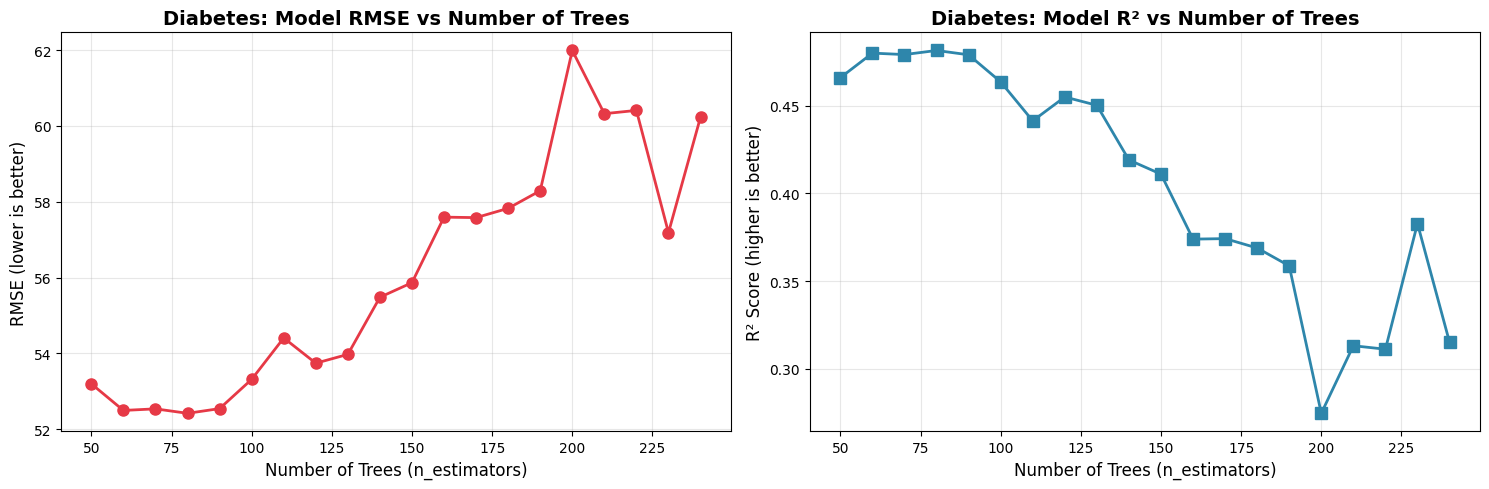

In [20]:
import matplotlib.pyplot as plt

# Extract data for visualization
n_est_values = [r[0] for r in sequential_results]
rmse_values = [r[3] for r in sequential_results]
r2_values = [r[4] for r in sequential_results]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE
ax1.plot(n_est_values, rmse_values, marker='o', linewidth=2, markersize=8, color='#E63946')
ax1.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax1.set_ylabel('RMSE (lower is better)', fontsize=12)
ax1.set_title('Diabetes: Model RMSE vs Number of Trees', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot R²
ax2.plot(n_est_values, r2_values, marker='s', linewidth=2, markersize=8, color='#2E86AB')
ax2.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax2.set_ylabel('R² Score (higher is better)', fontsize=12)
ax2.set_title('Diabetes: Model R² vs Number of Trees', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
ray.shutdown()
print("✓ Ray shutdown complete")

✓ Ray shutdown complete
